In [1]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [78]:
datos = []

def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        #'jet_kinematics', shape (N_jets, 4): [pt, eta, phi, softdrop mass]
        jet_pt, jet_eta, jet_phi, jet_mass = evento['jet_kinematics']
        constituents = evento['PFCands']

        # Calcular pT para cada constituyente
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Índices de los 10 con mayor pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convertir cada uno a formato usado en el circuito
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            pt = np.sqrt(px**2 + py**2)
            eta = 0.5 * np.log((E + pz) / (E - pz + 1e-8))  # evitar división por 0
            phi = np.arctan2(py, px)
            mass = np.sqrt(np.maximum(0, E**2 - (px**2 + py**2 + pz**2)))#En caso de que de masa negativa la pone a cero
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi,
                'mass': mass
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'constituents': top_constituents
        })

    return eventos

datos_background_qutrit = cargar_datos_json('runG_batch0_reducido.json')

In [79]:
len(datos_background_qutrit)

10000

In [90]:
import json
import numpy as np

def cargar_datos_json(json_path, num_jets=2000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extraer información del jet
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        
        # Extraer constituyentes (partículas)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        
        # Calcular pt, eta, phi para cada constituyente
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        theta = np.arccos(part_pz / (p_total + 1e-8))  # Evitar división por cero
        eta = -np.log(np.tan(theta / 2 + 1e-8))
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Seleccionar los num_constituents con mayor pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'constituents': top_constituents
        })

    return eventos

# Ejemplo de uso
datos_HToBB = cargar_datos_json('HToBB_120.json', num_jets=2000, num_constituents=10)
datos_ZToQQ = cargar_datos_json('ZToQQ_120.json', num_jets=2000, num_constituents=10)

In [3]:
#Añadir aqui datasets de pruebas

In [80]:
from sklearn.model_selection import train_test_split

datos_background_qutrit = np.array(datos_background_qutrit)

# Dividir en train y test (80% - 20%)
X_train, X_test = train_test_split(
    datos_background_qutrit, 
    test_size=0.2,      # 20% para test
    random_state=42,    # Semilla para reproducibilidad
    shuffle=True        # Mezclar datos antes de dividir
)


> ***“Each event is represented by a set of reconstructed jets ordered by decreasing transverse momentum (pT)…"***

### **Añadir la masa**

Siguiendo con lo especificado en el paper....

\begin{align}
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\eta - \eta_{\text{jet}}) \rightarrow \theta \tag{1} \\
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\phi - \phi_{\text{jet}}) \rightarrow \varphi \tag{2} \\
(p_T, \eta, \phi) \rightarrow |\psi\rangle = R_X(\varphi)R_Y(\theta) |0\rangle \notag \\
= \alpha(\theta, \varphi) |0\rangle + \beta(\theta, \varphi) |0\rangle \tag{3} \\
f \rightarrow 1 + \frac{2\pi}{1+e^{-w}} \tag{4}
\end{align}


In [81]:
num_jets_train = len(X_train)
num_jets_test = len(X_test)
print("Numbero de evetos de entrenamiento: ", num_jets_train)
print("Numbero de evetos de test: ", num_jets_test)

Numbero de evetos de entrenamiento:  8000
Numbero de evetos de test:  2000


---
---
---
---

# **Código del paper**

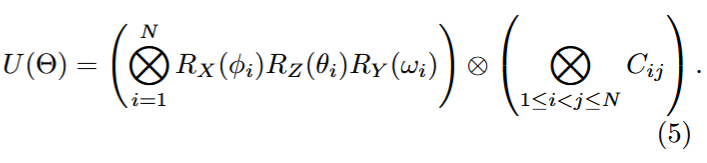

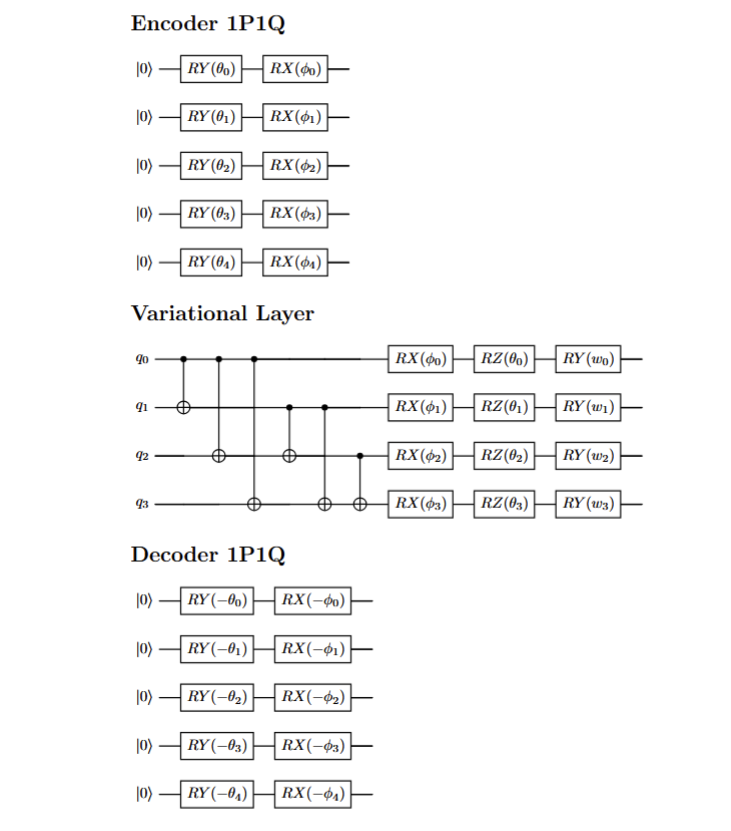

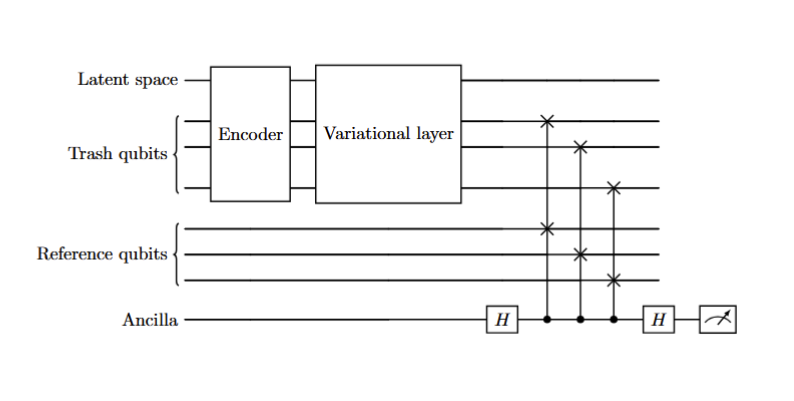

In [82]:
import pennylane as qml
import numpy as np
import torch
from scipy.linalg import expm

# Gell-Mann matrices (SU(3))
Lambda = {
    1: np.array([[0, 1, 0],
                 [1, 0, 0],
                 [0, 0, 0]], dtype=complex),

    2: np.array([[0, -1j, 0],
                 [1j, 0, 0],
                 [0, 0, 0]], dtype=complex),

    3: np.array([[1, 0, 0],
                 [0, -1, 0],
                 [0, 0, 0]], dtype=complex),

    4: np.array([[0, 0, 1],
                 [0, 0, 0],
                 [1, 0, 0]], dtype=complex),

    5: np.array([[0, 0, -1j],
                 [0, 0, 0],
                 [1j, 0, 0]], dtype=complex),

    6: np.array([[0, 0, 0],
                 [0, 0, 1],
                 [0, 1, 0]], dtype=complex),

    7: np.array([[0, 0, 0],
                 [0, 0, -1j],
                 [0, 1j, 0]], dtype=complex),

    8: (1/np.sqrt(3)) * np.array([[1, 0, 0],
                                  [0, 1, 0],
                                  [0, 0, -2]], dtype=complex)
}

# Spin-1 rotation generators (SO(3) ⊂ SU(3))
Sigma = {
    1: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ], dtype=torch.cdouble),

    2: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, -1j, 0],
        [1j, 0, -1j],
        [0, 1j, 0]
    ], dtype=torch.cdouble),

    3: torch.tensor([
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, -1]
    ], dtype=torch.cdouble)
}

def TSWAP_matrix():
    tswap = np.zeros((9, 9), dtype=complex)
    for i in range(3):
        for j in range(3):
            ket = np.zeros(9)
            bra = np.zeros(9)
            ket[3*i + j] = 1   # |i⟩|j⟩
            bra[3*j + i] = 1   # |j⟩|i⟩
            tswap += np.outer(bra, ket)
    return tswap
# Exponentiation function for any generator
def unitary_from_generator(generator_matrix, theta):
    return torch.matrix_exp(1j * theta * generator_matrix)

def RX_qutrit(theta, wire):
    qml.evolve(Sigma[1])(-theta)(wires=wire)

def RY_qutrit(theta, wire):
    qml.evolve(Sigma[2])(-theta)(wires=wire)

def RZ_qutrit(theta, wire):
    qml.evolve(Sigma[3])(-theta)(wires=wire)

In [93]:
# --- Parámetros del circuito ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qutrit", wires=wires)  # Cambiado a qutrits

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

# --- Funciones de codificación ---
def f(w): return 1 + (2 * np.pi / (1 + torch.exp(-w)))
def phi_circuit(w, phi, phi_jet, pt, pt_jet): return f(w) * pt / pt_jet * (phi - phi_jet)
def theta_circuit(w, eta, eta_jet, pt, pt_jet): return f(w) * pt / pt_jet * (eta - eta_jet)
def mass_circuit(w, mass, mass_jet, pt, pt_jet):  return  f(w) * pt / pt_jet * (mass - mass_jet)

# --- Encoder aproximado para qutrits ---
def encode_1p1q_qutrit(jets, w):
    pt_jet = jet['pt_jet']
    eta_jet = jet['eta_jet']
    phi_jet = jet['phi_jet']
    mass_jet = jet['mass_jet']
    constituents = jet['constituents']
        
    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        mass = mass_circuit(w, c['mass'], mass_jet, c['pt'], pt_jet)

        RX = unitary_from_generator(Sigma[1], theta)
        RY = unitary_from_generator(Sigma[2], phi)
        RZ = unitary_from_generator(Sigma[3], mass)

        qml.QutritUnitary(RX, wires=i)
        qml.QutritUnitary(RY, wires=i)
        qml.QutritUnitary(RZ, wires=i)
        

# --- Variational layer para qutrits ---
def variational_layer_qutrit(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.TAdd(wires=[i, j])
        for i in range(num_particles):

            RX = unitary_from_generator(Sigma[1], phi_i[layer, i])
            RY = unitary_from_generator(Sigma[2], theta_i[layer, i])
            RZ = unitary_from_generator(Sigma[3], w_i[layer, i])
    
            qml.QutritUnitary(RX, wires=i)
            qml.QutritUnitary(RZ, wires=i)
            qml.QutritUnitary(RY, wires=i)

# --- QAE Circuit con qutrits ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit_qutrit(jets, w, theta_i, phi_i, w_i, num_layers):
    encode_1p1q_qutrit(jets, w)
    variational_layer_qutrit(theta_i, phi_i, w_i, num_layers)

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.THadamard(wires=ancilla, subspace=None) #With none they apply the generalized version
        qml.ControlledQutritUnitary(tswap, control_wires=ancilla, wires=[trash_wire, ref_wire])
        qml.THadamard(wires=ancilla, subspace=None)
    
    return qml.probs(wires=ancilla)

# --- Función de costo ---
def cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()

In [84]:
from qiskit.visualization import array_to_latex

# Generar la matriz TSWAP
tswap = TSWAP_matrix()

# Convertir a LaTeX (parte real, ajusta precision si es compleja)
latex_code = array_to_latex(np.real(tswap).astype(int), prefix="\\text{TSWAP} = ")
display(latex_code)

<IPython.core.display.Latex object>

In [85]:
# --- Entrenamiento y evaluación unificados ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1  # Número de capas variacionales
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=0.01,              # Más típico y seguro
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,    # Regularización más suave
    amsgrad=True          
)

num_epochs = 1
all_fidelities = []
event_fidelities = []  # Lista para almacenar fidelidades por evento

# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []
    
    for jet in X_train:
        if len(jet['constituents']) < num_particles:
            continue
    
        loss, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i,  num_layers)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")


Epoch 1, Loss: -0.9836, Avg Fidelity: 98.36%


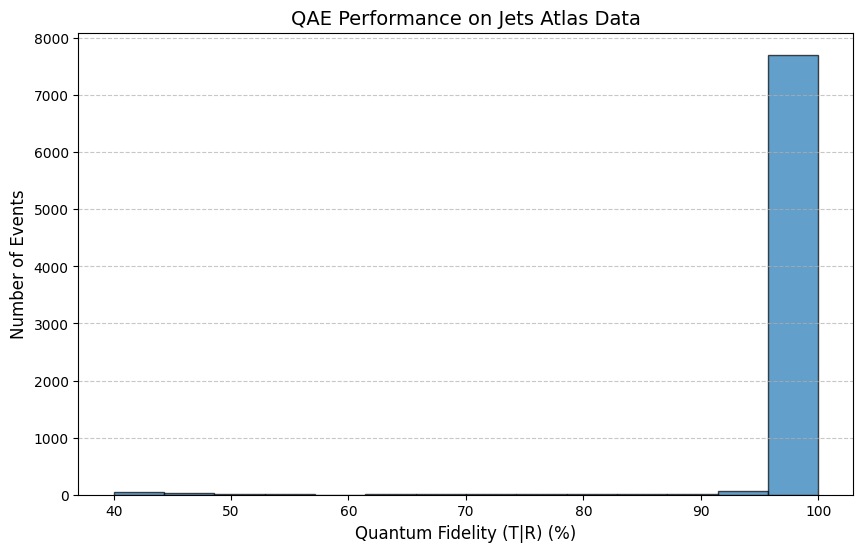

In [103]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(40, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

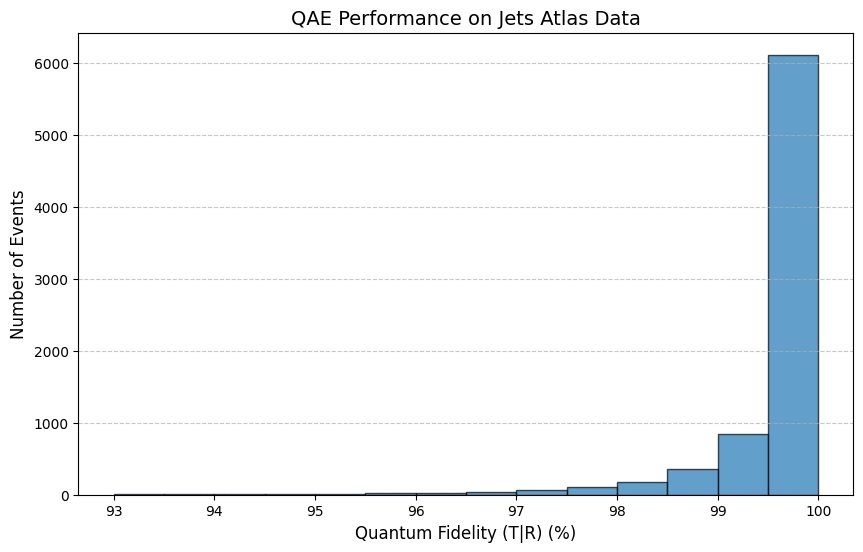

In [104]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(93, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

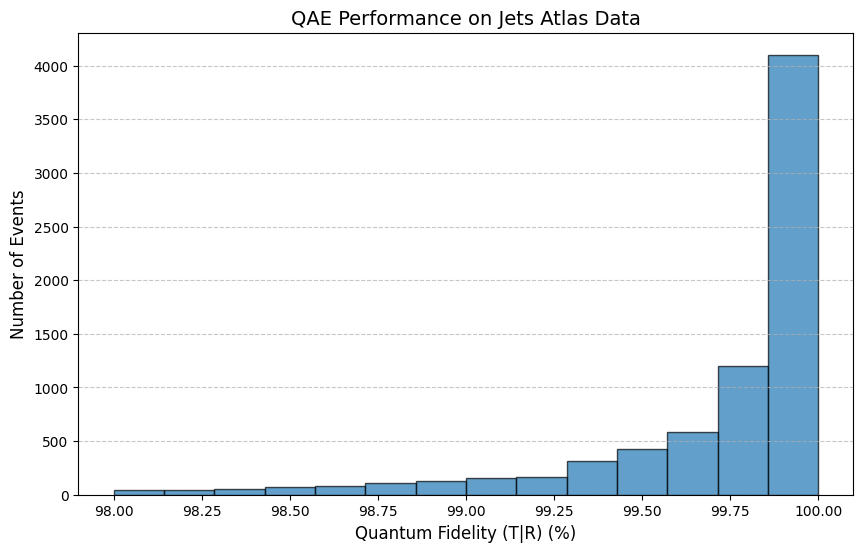

In [105]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(98, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [95]:
from sklearn.metrics import roc_auc_score

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_ZToQQ = []
fidelidades = []
etiquetas = []

for jet in X_test:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

print("Terminada prueba de validación")

for jet in datos_HToBB:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con HToBB")

for jet in datos_ZToQQ:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    
    _, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_ZToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con ZToQQ")

Terminada prueba de validación
Terminada prueba con HToBB
Terminada prueba con ZToQQ


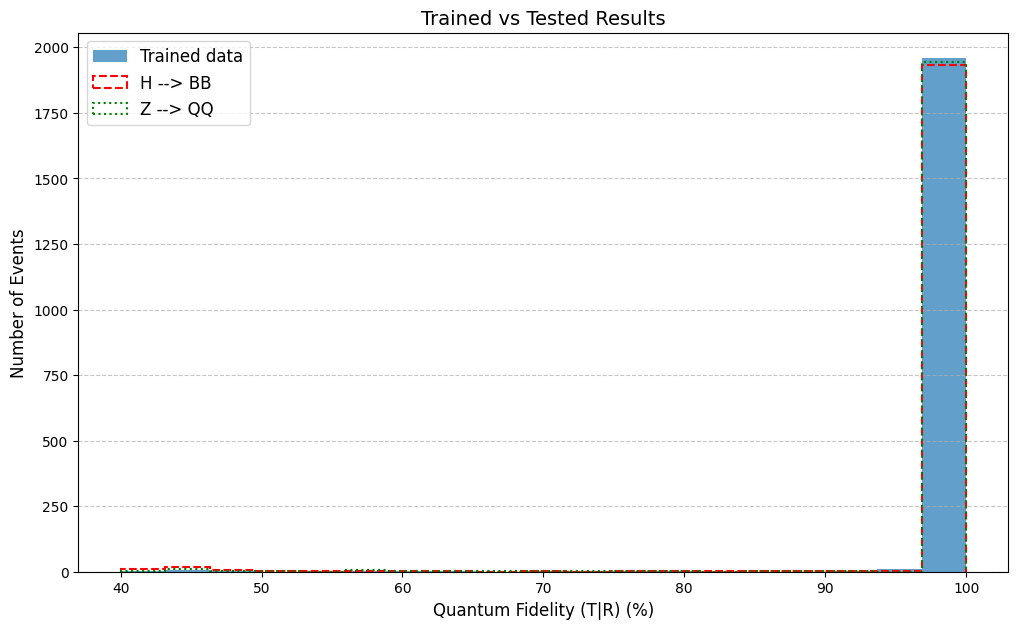

In [106]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(40, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(40, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show() 

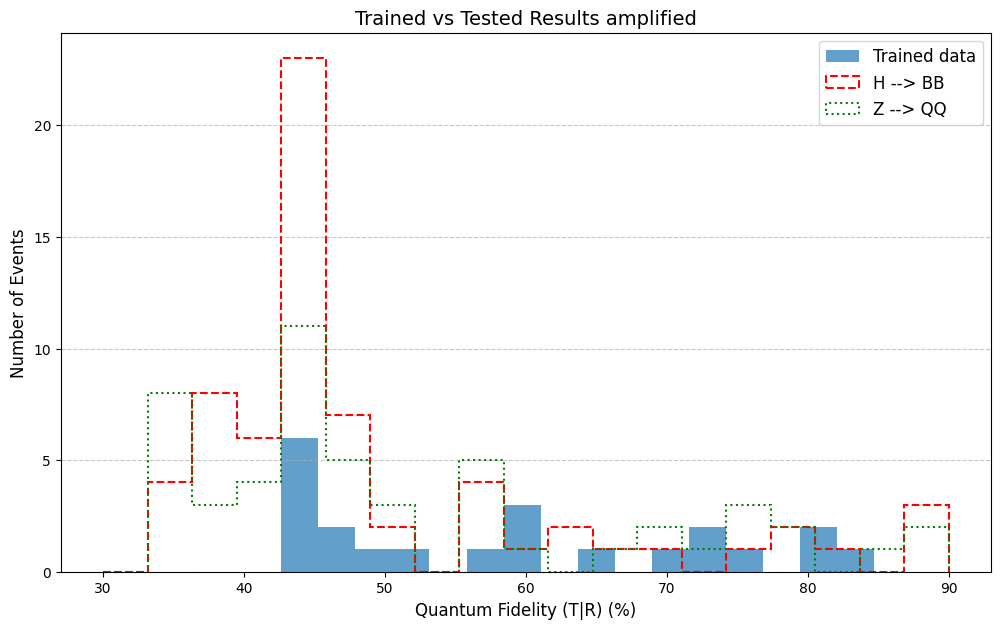

In [98]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(30, 90, 20)

plt.hist(event_fidelities_back, bins=np.linspace(40, 90, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results amplified", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

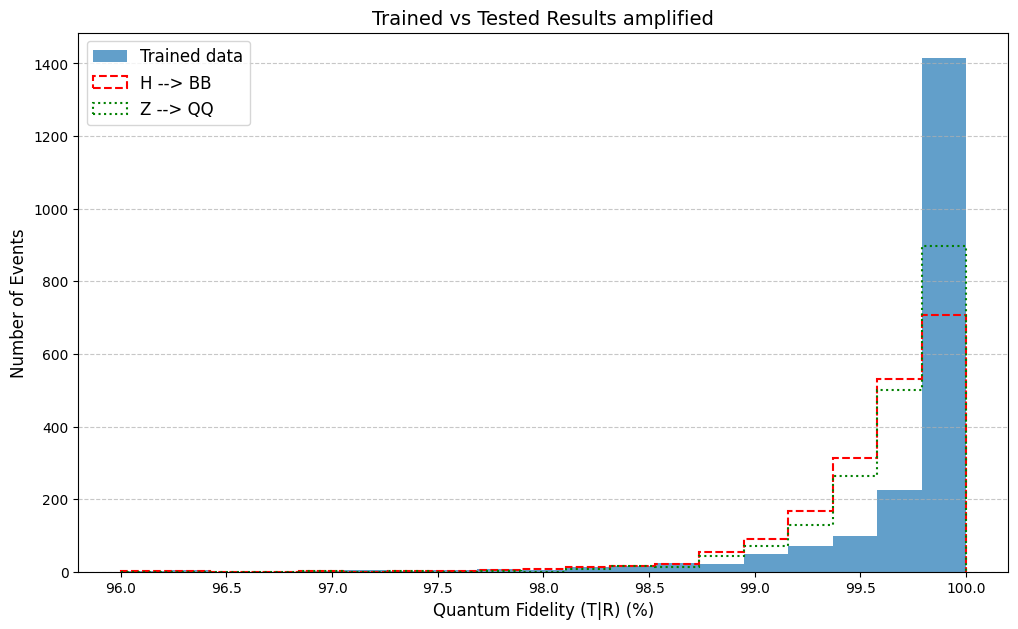

In [107]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(96, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(96, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results amplified", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

AUC (QCD vs HToBB): 0.7386
AUC (QCD vs ZToQQ): 0.6889


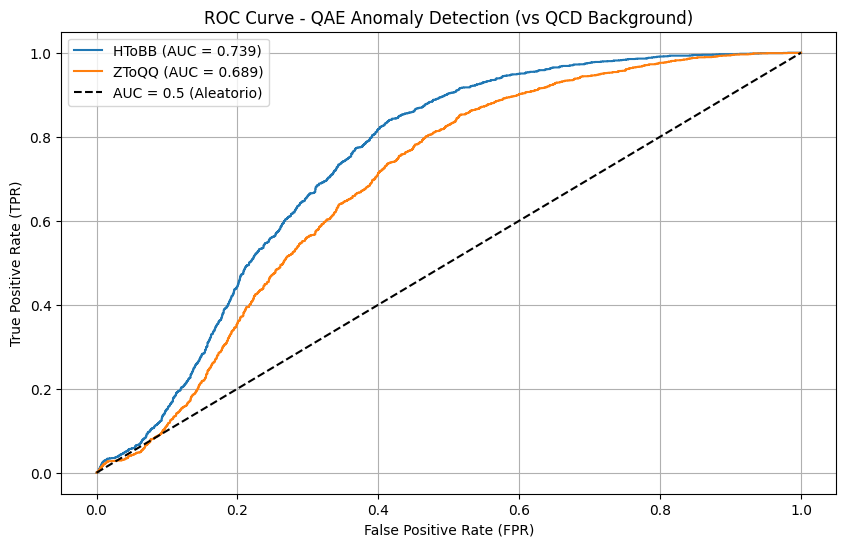

In [108]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular métricas de anomalía (1 - Fidelidad)
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_ZToQQ = 1 - np.array(event_fidelities_ZToQQ)

# 2. Calcular AUC para cada señal vs fondo
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_ZToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_ZToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_ZToQQ])
)

print(f"AUC (QCD vs HToBB): {auc_HToBB:.4f}")
print(f"AUC (QCD vs ZToQQ): {auc_ZToQQ:.4f}")

# 3. Graficar curvas ROC
plt.figure(figsize=(10, 6))

# Curva para HToBB
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, label=f'HToBB (AUC = {auc_HToBB:.3f})')

# Curva para ZToQQ
fpr_ZToQQ, tpr_ZToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_ZToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_ZToQQ])
)
plt.plot(fpr_ZToQQ, tpr_ZToQQ, label=f'ZToQQ (AUC = {auc_ZToQQ:.3f})')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', label='AUC = 0.5 (Aleatorio)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - QAE Anomaly Detection (vs QCD Background)')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
dev = qml.device("default.qutrit.mixed", wires=wires)

# --- Entrenamiento y evaluación unificados ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1  # Número de capas variacionales
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=0.01,              # Más típico y seguro
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,    # Regularización más suave
    amsgrad=True          
)

num_epochs = 1
all_fidelities = []
event_fidelities = []  # Lista para almacenar fidelidades por evento

# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []
    
    for jet in X_train:
        if len(jet['constituents']) < num_particles:
            continue
    
        loss, fidelity = cost_function_with_fidelity_qutrit(jet, w, theta_i, phi_i, w_i,  num_layers)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")


Epoch 1, Loss: -0.9780, Avg Fidelity: 97.80%
